In [1]:
from utils import *
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI Symbol','simHei','Arial','sans-serif']

## Load Data

In [73]:
years = [2016,2017]
resampling_period = '10T'  # 60 minutes

original_data = load_resample_data(years, resampling_period)
windfarms_names = original_data.columns.tolist()    

year:2016	(105408, 20)
year:2017	(105120, 20)
resampled to  (105264, 20)


### Normalize data = Capacity Factor (optional) 

In [74]:
windfarms = pd.read_excel('NRGstreamData/WindFarms.xlsx').sort_values(by='Asset ID').reset_index(drop = True)
normalized_data = original_data / windfarms['Capacity'].values

sum_capacities_each_row = np.array(~original_data.isnull().values * windfarms['Capacity'].values).sum(axis=1)
normalized_data['Total'] = original_data.sum(axis=1)/ sum_capacities_each_row

normalized_data.head(3)

,AKE1,ARD1,BSR1,BTR1,BUL1,BUL2,CR1,CRE3,CRR1,GWW1,...,IEW1,IEW2,KHW1,NEP1,OWF1,SCR2,SCR3,SCR4,TAB1,Total
DT,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.90,0.88,0.14,0.79,0.71,0.88,0.95,0.68,0.76,0.94,...,0.54,0.36,0.90,0.64,0.95,0.87,0.87,0.90,0.46,0.66
2016-01-01 00:10:00,0.88,0.82,0.14,0.74,0.71,0.88,0.95,0.67,0.71,0.92,...,0.54,0.39,0.92,0.64,0.95,0.87,0.87,0.91,0.46,0.65
2016-01-01 00:20:00,0.86,0.83,0.15,0.72,0.71,0.81,0.95,0.67,0.71,0.90,...,0.47,0.35,0.89,0.66,0.91,0.90,0.89,0.91,0.51,0.65


### Clustering (optional)

In [75]:
# from sklearn.cluster import KMeans
n_clusters = 5
# kmin = KMeans(n_clusters)
# X = np.transpose(normalized_data.iloc[:,:])
# Y = kmin.fit(X)
# clusters = kmin.labels_
# clusters

clusters = np.array([1, 1, 2, 1, 4, 4, 0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 2, 3, 2])

a = {}
for c in range(n_clusters):
    ind = clusters == c # OR: ind = np.where(clusters==c)[0] --> this generate an np.array of only indices
    # a[c] = (normalized_data.iloc[:,ind]).mean(axis=1) : old version
    a[c] = (original_data.iloc[:,ind]).sum(axis=1) / (windfarms['Capacity'].iloc[ind].sum())
    

clustered_data = pd.DataFrame.from_dict(a)
clustered_data.columns = ['Cluster {:d}'.format(d) for d in range(1,n_clusters+1)] 

clustered_data['Total'] = normalized_data['Total']

### Decide what data to use for further analysis (Original data | Normalized data | clustered_data)

In [76]:
# #### Be catious !
data = clustered_data  # Normalized_data  | Original_data
data.head()

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Total
DT,,,,,,
2016-01-01 00:00:00,0.71,0.88,0.26,0.87,0.80,0.66
2016-01-01 00:10:00,0.71,0.84,0.26,0.87,0.80,0.65
2016-01-01 00:20:00,0.68,0.84,0.28,0.88,0.77,0.65
2016-01-01 00:30:00,0.69,0.83,0.31,0.89,0.80,0.66
2016-01-01 00:40:00,0.69,0.82,0.33,0.90,0.80,0.67


In [77]:
CF_total = data['Total'].values * 100

In [83]:
def comp_prob_matrix_persistent_gen(CF_total, kind='low', CFs= None, period = np.arange(2, 24*5) ):
    """
    This function computes the probability of for how many consecutive hours the CF is below (low) or above(high) a threshold
    """
    if CFs is None:
        if kind=='low':
            CFs = np.arange(35,0,-1)
        else:
            CFs = np.arange(100,65,-0.2)
            
    # print(CFs)
    counts_mat = []
    for cf in CFs:
        if kind == 'low':
            c = ''.join(np.where(CF_total <= cf  , "T", "F"))
        else:
            c = ''.join(np.where(CF_total >= cf  , "T", "F"))
            
        counts = [len(re.findall('(?='+'T'*j+')',c)) for j in period]
        # events = [len(re.findall('T'*j + '+',c)) for j in range(1,period+1)] # it counts number of non-overlapping events
        counts_mat.append(counts)

    prob_matrix = np.array(counts_mat) / (CF_total.shape[0]) # len(years)
    return prob_matrix

In [98]:
period = np.arange(2,24*2 + 1)
CFs = np.around(np.arange(30,4,-1),2)  ; kind = 'low'
CFs = np.around(np.arange(90,64,-1),2); kind = 'high'

prob_matrix = comp_prob_matrix_persistent_gen(CF_total, kind=kind, CFs=CFs, period=period)

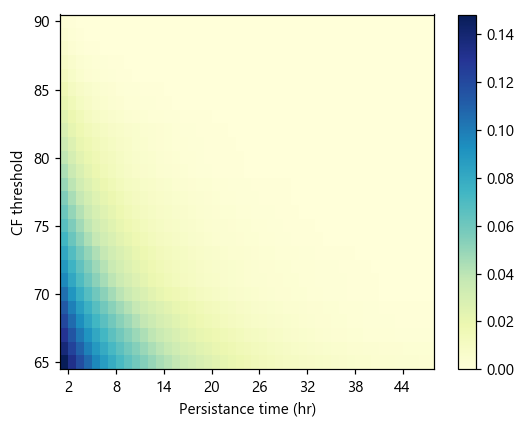

In [108]:
data_here = prob_matrix
d1 = data_here.shape[0]
d2 = data_here.shape[1]
x_lag = 6
y_leg = 5

fig, ax = plt.subplots(figsize=(5,4),dpi=110)
cax = ax.imshow(data_here, aspect='auto', cmap='YlGnBu') #norm=matplotlib.colors.LogNorm()

ax.set_xticks(np.arange(+.5, d2, x_lag))
ax.set_xticklabels(period[0::x_lag])

y_ticks_positions = np.arange(0, d1, y_leg)
# y_ticks_positions[-1] = y_ticks_positions[-1] + 1
ax.set_yticks(y_ticks_positions) #[-0.5,  4.5,  9.5, 14.5, 19.5, 24.5, 30.5]
ax.set_yticklabels(CFs[::y_leg])

# ax.spines['left'].set_position(('data', 0.0))

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax) #ticks=[0, .1, 0.2, 0.3, 0.4]
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar

ax.set_xlabel('Persistance time (hr)')
ax.set_ylabel('CF threshold')

fig.tight_layout()
fig.savefig('persistence_of_{}_genertation_imageshow.jpg'.format(kind), papertype='letter', dpi = 300, bbox_inches='tight')    

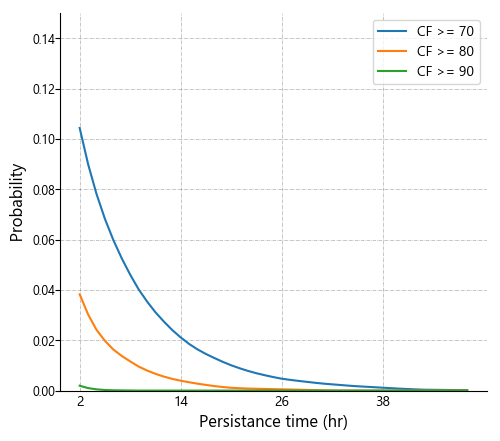

In [107]:
CFs_short = np.array([30,20,10]); kind = 'low'
CFs_short = np.array([70,80,90]); kind = 'high'

prob_matrix_short = comp_prob_matrix_persistent_gen(CF_total, kind=kind, CFs=CFs_short, period=period)
data_here = prob_matrix_short

fig, ax = plt.subplots(figsize=(5.5,5),dpi = 100)

d1 = data_here.shape[0]
d2 = data_here.shape[1]
x_leg = 12
y_leg = 5

# ax.set_xmargin(0)
ax.set_ymargin(0)

ax.set_xticks(np.arange(0, d2, x_leg))
ax.set_xticklabels(period[0::x_leg])

# ax.set_yticks(np.arange(-0.5, d1, CF_leg))
# ax.set_yticklabels(CFs[0::CF_leg])

ax.tick_params(axis='x', labelsize = 10, which='both', pad=0, rotation=0 , color = 'w')
ax.tick_params(axis='y', labelsize = 9, which='both', pad=0, rotation=0 , color = 'k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(color='k', linestyle='-.', linewidth=0.4, alpha = 0.4, which = 'both')

ax.set_xlabel('Persistance time (hr)',fontsize=12)
ax.set_ylabel(' Probability ', fontsize=12)

for i,cf in enumerate(CFs_short):
    ax.plot(data_here[i,:], label = "CF >= {}".format(cf))

# ax.spines['bottom'].set_position('zero')
ax.set_ylim(0,0.15)

ax.legend()
plt.show()

fig.tight_layout()
fig.savefig('persistence_of_{}_genertation_curves.jpg'.format(kind), papertype='letter', dpi = 300, bbox_inches='tight')    

In [ ]:
dx, dy = 0.15, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-3, 3 + dy, dy),
                slice(-3, 3 + dx, dx)]
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, axs = plt.subplots(2, 2)

ax = axs[0, 0]
c = ax.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolor')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

ax = axs[0, 1]
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

ax = axs[1, 0]
c = ax.imshow(z, cmap='RdBu', vmin=z_min, vmax=z_max,
              extent=[x.min(), x.max(), y.min(), y.max()],
              interpolation='nearest', origin='lower')
ax.set_title('image (nearest)')
fig.colorbar(c, ax=ax)

ax = axs[1, 1]
c = ax.pcolorfast(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolorfast')
fig.colorbar(c, ax=ax)

fig.tight_layout()
plt.show()


In [144]:
class Singleton:
    __instance = None
       
    @staticmethod 
    def getInstance():
        """ Static access method. """
        if Singleton.__instance == None:
            print("alaki")
            Singleton()
        return Singleton.__instance
    
    def __init__(self):
        """ Virtually private constructor. """
        if Singleton.__instance != None:
            print("k", Singleton.__instance)
            raise Exception("This class is a singleton!")
        else:
            print("::)")
            Singleton.__instance = self

# s = Singleton()
# print(s)

s = Singleton.getInstance()
print(s)
# s = Singleton.getInstance()
# print(s)


alaki
::)
